## Purpose: Check whether or not the maximum likelihood method works with the 2D dataset (energy and $\theta$) as well.
#### Note that this project is based on the EventDisplay dataset.

In [1]:
%load_ext autoreload
%autoreload 2

from DarkMatter import *

Welcome to JupyROOT 6.23/01


## 1. Generate a pseudo signal.
#### Assuming that $<\sigma\nu> = 10^{-22.5}$.

In [2]:
M = 1000
dwarf="segue_1"
sigma = -22.5
jSeed = defaultNum[dwarf]
hg_2d = Likelihood.combinedCalcSignal(dwarf, M, "EventDisplay", decay="tt", jSeed=jSeed, sigma=sigma, addTheta=True, ext=True, averagedIRF=True)

Warning in <TROOT::Append>: Replacing existing TH1: DMspec (Potential memory leak).


(<cppyy.gbl.TCanvas object at 0x7f8e841a2c50>,
 <cppyy.gbl.TH2D object at 0x7f8e7ee07400>)

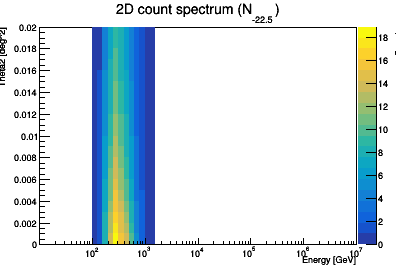

In [3]:
plotRoot(hg_2d, logx=True)

## 2. Generate a pseudo "on-region" count spectrum.
#### The pseudo signal + observed background

In [4]:
hOn_2d, hOff_2d, n1, n2, evts, alpha = Likelihood.eventdisplay.readData(dwarf, addTheta=True, 
                                                                        ext=True, full_output=True,
                                                                        bkgModel="ex")

The number of DM events:  1175
The number of background events:  2664
The number of the total events:  3839


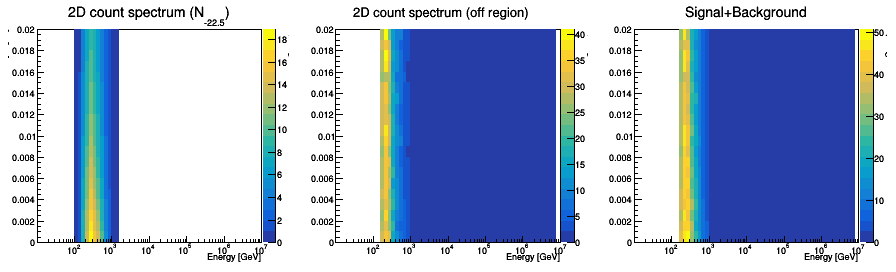

In [5]:
N_tot = 0
N_bkg = 0
N_sig = 0
hOn_2d.SetTitle("Signal+Background")
hOn_2d.Reset()
for i in range(1, hOn_2d.GetNbinsX()+1):
    for j in range(1, hOn_2d.GetNbinsY()+1):
        if hOff_2d.GetXaxis().GetBinCenter(i) != hg_2d.GetXaxis().GetBinCenter(i):
            continue
        if hOff_2d.GetYaxis().GetBinCenter(j) != hg_2d.GetYaxis().GetBinCenter(j):
            continue

        E = hOff_2d.GetXaxis().GetBinCenter(i)
        if E >min(evts[:,0]):
            N_bkg += hOff_2d.GetBinContent(i, j)
            N_sig += hg_2d.GetBinContent(i, j)
            total = hOff_2d.GetBinContent(i, j)+hg_2d.GetBinContent(i, j)
            hOn_2d.SetBinContent(i, j, total)
            N_tot+=total
        
c = TCanvas("Observation", "Observation", 900,300)
c.Divide(3,1)
c.cd(1)
hg_2d.Draw("colz")
gPad.SetLogx()
c.cd(2)
hOff_2d.Draw("colz")
gPad.SetLogx()
c.cd(3)
hOn_2d.Draw("colz")
gPad.SetLogx()
c.Draw()

print("The number of DM events: ", round(N_sig))
print("The number of background events: ", round(N_bkg))
print("The number of the total events: ", round(N_tot))

## 3. Generate events based on the pseudo count spectrum

### 3.1 Generate events.

In [53]:
from DarkMatter.Likelihood.simulation import generateFakeEvents

events = generateFakeEvents(dwarf, M, sigma, addTheta=True)

### 3.2 Check the consistency

Warning in <TROOT::Append>: Replacing existing TH1: h_dff (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: Pseudo count spectrum


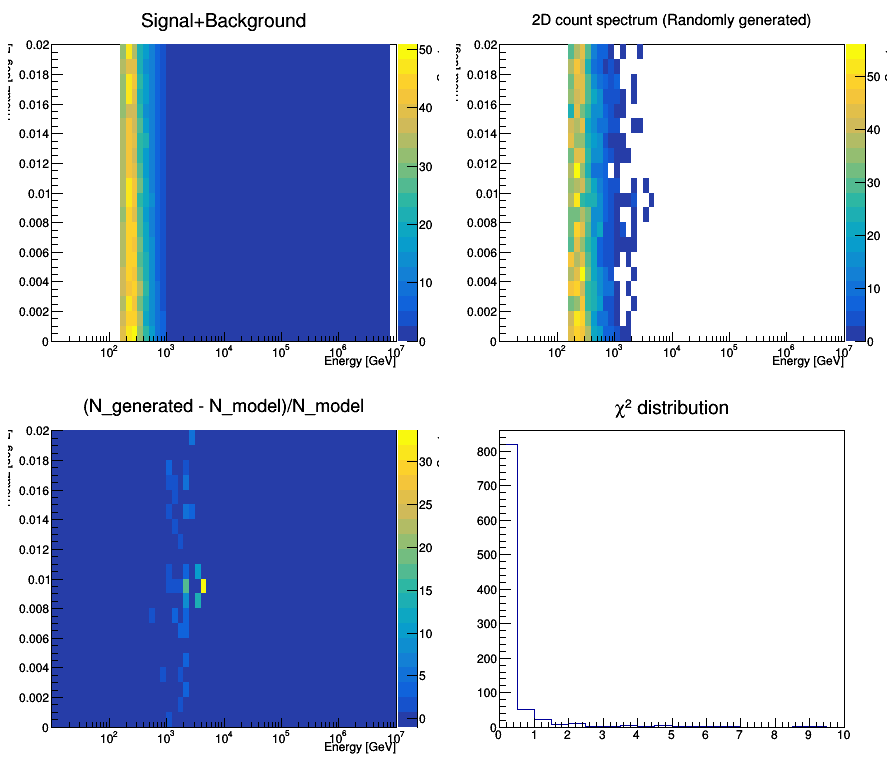

In [51]:
hGen = hOn_2d.Clone()
hGen.Reset()
hGen.SetTitle("2D count spectrum (Randomly generated)")
hGen.GetXaxis().SetTitle("Energy [GeV]")
hGen.GetYaxis().SetTitle("Theta [deg]")
hGen.GetZaxis().SetTitle("Counts")

for evt in events:
    hGen.Fill(evt[0], evt[1])
    
hDiff = hOn_2d.Clone()
hDiff.Reset()
hDiff.SetTitle("(N_generated - N_model)/N_model")
hDiff_dist = TH1D("h_dff", "#chi^{2} distribution", 20, 0, 10)
for i in range(1, hOn_2d.GetNbinsX()+1):
    for j in range(1, hOn_2d.GetNbinsY()+1):
        
        if hOn_2d.GetBinContent(i, j) !=0:
            diff = (hGen.GetBinContent(i, j)-hOn_2d.GetBinContent(i, j))/hOn_2d.GetBinContent(i, j)
            chisq = (hOn_2d.GetBinContent(i, j)-hGen.GetBinContent(i, j))**2/hOn_2d.GetBinContent(i, j)
            hDiff.SetBinContent(i, j, diff)
            hDiff_dist.Fill(chisq)

c = TCanvas("Pseudo count spectrum", "Pseudo count spectrum", 900,800)
c.Divide(2,2)
c.cd(1)
hOn_2d.Draw("colz")
gPad.SetLogx()
c.cd(2)
hGen.Draw("colz")
gPad.SetLogx()
c.cd(3)
hDiff.Draw("colz")
gPad.SetLogx()
c.cd(4)
hDiff_dist.Draw()
c.Draw()

## 4. Perform the maximum likelihood estimation with the pseudo data.
#### To do this, you need to update args.

In [52]:
mle = Likelihood.MLE(dwarf, M, package="EventDisplay", jArray=True, jSeed=jSeed, ext=True,
                     addTheta=True, decay="tt", averagedIRF=True, bkgModel="ex", useBias=True,
                     verbose=True) 

mle.N_on = int(N_tot)
mle.events = events
mle.updateArgs(forced=True)

mle.minuit()

[Log] Initializing... (EventDisplay)
[Log] Step 1: Instrument response functions are imported.
[Log] Step 2: Events are loaded.
[Log] Step 3: A source model is loaded.
[Log] Step 4: A temporary file for minimization is generated.
[Log] Initialization is done. Run minuite.
[Log, Result] TS = 455.69 (M=1000 GeV)
[Log, Result] <σν> = 10^(-22.528 +/- 0.033)
[Log, Result] b = 15323 +/- 172 (null value: 16272)
[Log, Result] N_on = 3839, N_off = 2673, N_dm = 1115


Warning in <TROOT::Append>: Replacing existing TH1: hOn (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hOn (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: DMspec (Potential memory leak).


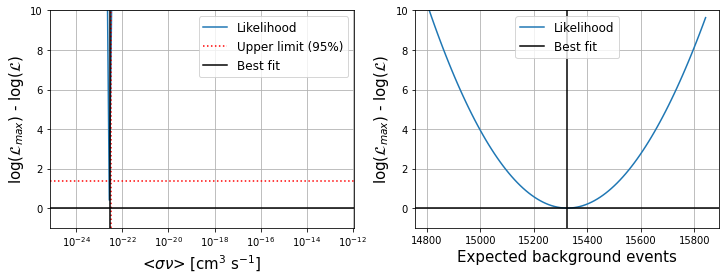

In [17]:
mle.plotProfileLikelihood(invert=True)

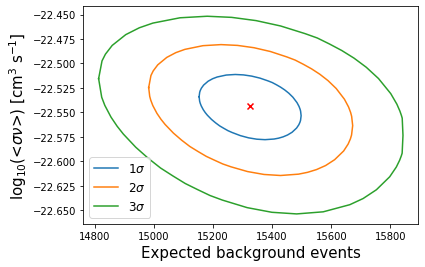

 FUNCTION MUST BE MINIMIZED BEFORE CALLING SCAn      


In [18]:
mle.plotContour()

### - Quick check: Compare TS value between 1D and 2D

[Log] Initializing... (EventDisplay)
[Log] Step 1: Instrument response functions are imported.
[Log] Step 2: Events are loaded.
[Log] Step 3: A source model is loaded.
[Log] Step 4: A temporary file for minimization is generated.
[Log] Initialization is done. Run minuite.
[Log, Result] TS = 426.05 (M=1000 GeV)
[Log, Result] <σν> = 10^(-22.537 +/- 0.033)
[Log, Result] b = 15310 +/- 173 (null value: 16272)
[Log, Result] N_on = 3838, N_off = 2671, N_dm = 1130
TS value: 426.05


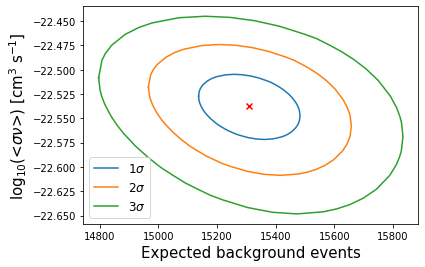

Warning in <TROOT::Append>: Replacing existing TH1: DMspec (Potential memory leak).


In [35]:
mle = Likelihood.MLE(dwarf, M, package="EventDisplay", jArray=True, jSeed=jSeed, ext=True,
                     decay="tt", averagedIRF=True, verbose=True, bkgModel="ex") 
mle.N_on = int(N_tot)
mle.events = events
mle.updateArgs()
mle.minuit()
print("TS value: {:.2f}".format(mle.ts))
mle.plotContour()

## Conclusion
<font size=3>The maximum likelihood estimation works properly with the angular extension. The assumed $<\sigma\nu>$ was $10^{-22.5}$, and the MLE found the best-fit value of $10^{-22.51+/-0.04 (1 \sigma)}$ with TS of 386. </font>